<a href="https://colab.research.google.com/github/pkaysantana/AI-Powered-Pharma-Optimisation/blob/main/Atorvastatin_Production_AI_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

In [ ]:
# Import necessary libraries
import numpy as numpy   # For generating random numbers and performing mathematical operations
import pandas as pd     # For handling and storing the data in DataFrame format
import simpy            # For event-driven simulation of sensor data over time
import random           # To introduce randomness (e.g., sensor noise)

# Set a random seed for reproducibility (so results are the same each time)
random.seed(42)

# Simulation setup parameters
sim_duration = 24                                       # Total simulation time in hours (e.g., simulating for 1 day)
data_points_per_day = 1000                              # Number of data points to generate per day
sampling_interval = sim_duration / data_points_per_day  # Time interval between each data point

# Create a SimPy environment (this will handle the scheduling of the simulation)
env = simpy.Environment()

# List to store the simulated sensor data
sensor_data_list = []

# Function to simulate sensor data generation
def generate_sensor_data(env):
    """
    This function simulates the generation of sensor data at regular intervals.
    It generates random values for temperature, pressure, vibration, and humidity, and stores them in the sensor_data list.
    """
    while True:
        # Generate sensor readings with noise
        temperature = random.uniform(18, 28) + random.gauss(0, 0.5) #Temperature between 18C to 28C with noise
        pressure = random.uniform(0, 100) + random.gauss(0, 2)       # Pressure between 0 and 100 psi with noise
        vibration = random.uniform(0.1,2) + random.gauss(0, 0.1)    # Vibration between 0.1 and 2 with noise
        humidity = random.uniform(20,80) + random.gauss(0, 2)       # Humidity between 20% and 80% with noise

        # Create a dictionary to store the generated sensor data for this timestamp
        sensor_data = {
            'timestamp': env.now, #Timestamp of the data collection (in simylation time)
            'temperature': temperature,
            'pressure': pressure,
            'vibration': vibration,
            'humidity': humidity
        }

        # Append the data to the list
        sensor_data_list.append(sensor_data)

        #Print the current sensor data (for debugging or real-time monitoring)
        print(sensor_data)

        # Wait for the next sampling interval
        yield env.timeout(sampling_interval)

# Start the sensor data generation process in the SimPy environment
env.process(generate_sensor_data(env))

# Run the simulation for the specified duration (24 hours)
env.run(until=sim_duration)

# After simulation is complete, convert the list of sensor data into a pandas DataFrame for easy manipulation
df = pd.DataFrame(sensor_data_list)

# Display the first few rows of the DataFrame to confirm the simulation ran correctly
print(df.head())

# Save the data to a CSV file for future use or analysis
df.to_csv('simulated_sensor_data.csv', index=False) # Data saved without row indices

{'timestamp': 0, 'temperature': 24.790340355053736, 'pressure': 22.572110366288797, 'vibration': 1.4054901847683001, 'humidity': 21.434988341316977}
{'timestamp': 0.024, 'temperature': 22.564304696435006, 'pressure': 50.79702162586881, 'vibration': 0.19619342226737543, 'humidity': 55.44563285479417}
{'timestamp': 0.048, 'temperature': 19.433468541315086, 'pressure': -1.2872317403731741, 'vibration': 1.6018613735473282, 'humidity': 27.60070265914192}
{'timestamp': 0.07200000000000001, 'temperature': 27.457937176301943, 'pressure': 10.426633416053784, 'vibration': 1.5660008885053023, 'humidity': 61.583009150910684}
{'timestamp': 0.096, 'temperature': 23.84302545081215, 'pressure': 54.876111124109926, 'vibration': 1.529605136849993, 'humidity': 51.94487046453231}
{'timestamp': 0.12, 'temperature': 25.39052544715951, 'pressure': 29.347258046057487, 'vibration': 0.25658474321532043, 'humidity': 37.595951236422714}
{'timestamp': 0.144, 'temperature': 24.03927115595885, 'pressure': 22.3946342

In [ ]:
import pandas as pd

# Load the dataset (assuming it was saved as a CSV)
df = pd.read_csv('simulated_sensor_data.csv')

# Inspect the first few rows of the dataframe
print(df.head())

   timestamp  temperature   pressure  vibration   humidity
0      0.000    24.790340  22.572110   1.405490  21.434988
1      0.024    22.564305  50.797022   0.196193  55.445633
2      0.048    19.433469  -1.287232   1.601861  27.600703
3      0.072    27.457937  10.426633   1.566001  61.583009
4      0.096    23.843025  54.876111   1.529605  51.944870


In [ ]:
"""
In most cases, imputation (filling missing data) is optimal, especially if the missing data is significant and you want to retain all rows of your dataset for training your machine learning models. However, if missing data is minimal, removing it is a simpler and quicker approach.
"""
# Fill missing data with the mean of the column for simplicity
df_cleaned = df.fillna(df.mean())

Outliers can significantly affect the performance of machine learning models. To remove outliers, you can use z-scores or other statistical techniques.
Z-scores are a standard measure to identify values that are far away from the mean (e.g., more than 3 standard deviations).

In [ ]:
from scipy.stats import zscore

# Apply z-score to remove outliers in all sensor data columns
df_cleaned['temperature_zscore'] = zscore(df_cleaned['temperature'])
df_cleaned['pressure_zscore'] = zscore(df_cleaned['pressure'])
df_cleaned['vibration_zscore'] = zscore(df_cleaned['vibration'])
df_cleaned['humidity_zscore'] = zscore(df_cleaned['humidity'])

# Keep rows where z-score is less than 3 (i.e., within 3 standard deviations)
df_cleaned = df_cleaned[(df_cleaned['temperature_zscore'].abs() < 3) &
                        (df_cleaned['pressure_zscore'].abs() < 3) &
                        (df_cleaned['vibration_zscore'].abs() < 3) &
                        (df_cleaned['humidity_zscore'].abs() < 3)]

This will remove extreme outliers (those with a z-score greater than 3) and keep the dataset within reasonable limits.

Normalization scales the data to a specific range, often between 0 and 1. This is essential for machine learning models that depend on the scale of the input data (such as neural networks or k-nearest neighbors).

In [ ]:
# Using MinMaxScaler from scikit-learn to scale the data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the selected sensor columns (temperature, pressure, vibration, humidity)
df_cleaned[['temperature', 'pressure', 'vibration', 'humidity']] = scaler.fit_transform(
    df_cleaned[['temperature', 'pressure', 'vibration', 'humidity']])

Normalisation Techniques for Sensor Data Preprocessing
In this project, sensor data collected from pharmaceutical manufacturing processes is preprocessed to ensure it is suitable for use in machine learning models. Two popular normalisation techniques are compared: Min-Max Normalisation and Z-Score Normalisation (Standardisation). Each technique has its advantages and the choice between them depends on the nature of the data and the machine learning algorithms being used.

1. Min-Max Normalisation
Min-Max Normalisation transforms data to a fixed range, typically between 0 and 1. This technique is commonly used when the data has a known range and when the machine learning models used require features to be within the same scale.

When to use Min-Max Normalisation:

When the data is bounded, such as temperature (e.g., 18°C to 28°C) or pressure (e.g., 0 to 100 psi).

When using algorithms that are sensitive to magnitude and require a consistent scale, such as neural networks or K-nearest neighbours (KNN).

Drawback:

Min-Max Normalisation is sensitive to outliers, which means that the presence of outliers can compress the remaining values into a narrow range.

2. Z-Score Normalisation (Standardisation)
Z-Score Normalisation, also known as Standardisation, transforms the data to have a mean of 0 and a standard deviation of 1. This technique is more robust to outliers and is commonly used when the data is not bound to a specific range.

When to use Z-Score Normalisation:

When the data includes outliers that should not disproportionately affect the scaling.

When the machine learning model assumes that the data is normally distributed or when models such as Support Vector Machines (SVM), Logistic Regression, or PCA are used.

Advantages:

More robust to outliers compared to Min-Max Normalisation.

Works well for models that assume Gaussian distributions (i.e., data distributed around a mean of 0).

Drawback:

The transformed data does not lie within a fixed range like [0, 1], which may not be ideal for models that need bounded inputs.

Optimal Choice for the Project
For this project, which involves multiple sensor types (temperature, pressure, vibration, and humidity), Z-Score Normalisation is preferred because it is more robust to outliers and handles the natural variations in sensor data more effectively. Since sensor data often includes occasional spikes or anomalies (e.g., temperature spikes, pressure surges), Z-Score Normalisation will ensure that such outliers do not distort the model's learning process.

If the data had fewer outliers and was known to have a bounded range, Min-Max Normalisation would be considered a suitable option.

In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the dataset (simulated sensor data)
df = pd.read_csv('simulated_sensor_data.csv')

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply Z-Score Normalisation to the relevant columns
df[['temperature', 'pressure', 'vibration', 'humidity']] = scaler.fit_transform(
    df[['temperature', 'pressure', 'vibration', 'humidity']])

# Inspect the first few rows of the normalised data
df.head()

,timestamp,temperature,pressure,vibration,humidity
0,0.000,0.639593,-0.948968,0.640927,-1.668099
1,0.024,-0.134305,0.047244,-1.534878,0.302120
2,0.048,-1.222765,-1.791095,0.994245,-1.310923
3,0.072,1.567004,-1.377648,0.929723,0.657655
4,0.096,0.310252,0.191218,0.864239,0.099322


**Feature Engineering** is the process of creating new features that more effectively represent the data, making it more suitable for machine learning models. In this project, multiple sensor types (temperature, pressure, vibration, and humidity) are being used, and it is important to extract meaningful features from the raw data to improve the performance of predictive maintenance models.

The first step in feature engineering involves extracting key features from the raw sensor data, such as Root Mean Square (RMS), kurtosis, and spectral entropy. These features capture important characteristics of the data, especially for the vibration sensor data, which can reveal valuable insights for predictive maintenance.

Root Mean Square (RMS): Measures the magnitude of variations in vibration signals.

Kurtosis: Captures the "tailedness" or peakiness of the data distribution, which is useful for detecting anomalies in equipment behavior.

These features will be expanded to include not only vibration but also temperature, pressure, and humidity sensor data.

In [ ]:
import numpy as np
from scipy.stats import kurtosis
from scipy.signal import welch

# Feature extraction for vibration data
rms_vibration = np.sqrt(np.mean(df_cleaned['vibration']**2))
kurtosis_vibration = kurtosis(df_cleaned['vibration'])

# Feature extraction for temperature, pressure, and humidity (simplified examples)
# Mean values for each sensor reading
mean_temperature = np.mean(df_cleaned['temperature'])
mean_pressure = np.mean(df_cleaned['pressure'])
mean_humidity = np.mean(df_cleaned['humidity'])

# Add extracted features to the DataFrame
df_cleaned['rms_vibration'] = rms_vibration
df_cleaned['kurtosis_vibration'] = kurtosis_vibration
df_cleaned['mean_temperature'] = mean_temperature
df_cleaned['mean_pressure'] = mean_pressure
df_cleaned['mean_humidity'] = mean_humidity

By adding these features to the dataset, the model can better capture the relationships and patterns that may indicate equipment failures or anomalies.

When dealing with time-series data, such as sensor readings over time, it’s useful to **smooth the data** using a **rolling window**. This technique helps to reduce high-frequency noise and makes trends and patterns in the data more apparent, which can improve predictive model accuracy.

The **rolling mean** technique is applied to each sensor's readings to create smoother data over a window of time. This step is crucial for handling time-series sensor data, where the objective is to predict failures or anomalies based on past trends.

In [ ]:
# Apply rolling mean for smoothing over the last 5 data points
df_cleaned['rolling_temperature'] = df_cleaned['temperature'].rolling(window=5).mean()
df_cleaned['rolling_pressure'] = df_cleaned['pressure'].rolling(window=5).mean()
df_cleaned['rolling_vibration'] = df_cleaned['vibration'].rolling(window=5).mean()
df_cleaned['rolling_humidity'] = df_cleaned['humidity'].rolling(window=5).mean()

**Save the Cleaned Data**

After completing the preprocessing steps, the cleaned and feature-engineered data should be saved for use in the next phases of the project. This step ensures that the processed data is available for further analysis or model training without needing to re-run the preprocessing steps.

In [ ]:
# Save the cleaned and processed data to a new CSV file
df_cleaned.to_csv('cleaned_sensor_data.csv', index=False)

By saving the cleaned data to a **CSV file**, the team can continue working with the prepared dataset at any point in the project, improving workflow efficiency and avoiding redundant computations.

Feature Engineering

Feature engineering is a critical step in preparing the data for machine learning models. For this task, the goal is to extract meaningful features such as **RMS vibration**,** kurtosis**, and **spectral entropy** using **SciPy** and **NumPy**. These features will help capture key patterns in the data that could be indicative of equipment failure or anomalies in the manufacturing process.

Objective:
**RMS vibration**: Captures the magnitude of variations in the vibration signal.

**Kurtosis**: Measures the "tailedness" or peakiness of the data, useful for detecting abnormalities.

**Spectral Entropy**: Captures the randomness or complexity in the vibration signal, which is useful for identifying equipment malfunctions.

The goal is to ensure that these features are **suitable for machine learning models** by maintaining their relevance to predictive maintenance and ensuring they capture useful patterns.

Extracting RMS Vibration

RMS (Root Mean Square) is a measure of the magnitude of a varying signal, often used to quantify the intensity of vibrations in machinery. The formula for RMS is:
$$RMS = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}$$

Where \(x_i\) represents the individual sensor reading and \(N\) is the total number of readings.



In [ ]:
# Calculate RMS vibration
rms_vibration = np.sqrt(np.mean(df_cleaned['vibration']**2))

# Add RMS feature to the DataFrame
df_cleaned['rms_vibration'] = rms_vibration

**Calculating Kurtosis**

Kurtosis measures the "tailedness" or sharpness of the peak of a data distribution. High kurtosis indicates a dataset with outliers or rare extreme events, which might be indicative of equipment failure.

In [ ]:
from scipy.stats import kurtosis

# Calculate kurtosis for vibration signal
kurtosis_vibration = kurtosis(df_cleaned['vibration'])

# Add kurtosis feature to the DataFrame
df_cleaned['kurtosis_vibration'] = kurtosis_vibration

** Calculating Spectral Entropy**

Spectral entropy measures the amount of randomness or unpredictability in a signal. It is often used to quantify the complexity of a signal, and higher entropy values indicate more complexity. For machinery monitoring, an increase in spectral entropy could indicate anomalous behaviour.

In [ ]:
from scipy.signal import welch
import numpy as np

# Compute the power spectral density (PSD) of the vibration signal
f, Pxx = welch(df_cleaned['vibration'], fs=1.0)  # fs = 1 Hz for simplicity

# Calculate the spectral entropy
spectral_entropy = -np.sum(Pxx * np.log2(Pxx + 1e-9))  # Avoid log(0) with small value

# Add spectral entropy feature to the DataFrame
df_cleaned['spectral_entropy'] = spectral_entropy

 **Feature Selection and Suitability for Machine Learning**

Once the features are extracted, it’s important to ensure that the features are **suitable for machine learning models**:

Scale the Features: If needed, the extracted features (like RMS, kurtosis, and spectral entropy) can be standardised or normalised to ensure they are on the same scale. Since we’ve already applied Z-Score Normalisation, this step is not necessary unless new features require separate scaling.

Check for Feature Importance: After training a machine learning model, it’s useful to assess the importance of each feature to ensure that these extracted features (RMS, kurtosis, spectral entropy) are contributing meaningfully to model predictions.

**Create the Failure Label Using the Percentile-Based Method**

In this task, the goal is to capture rare events that could potentially indicate **equipment failures** based on sensor readings. Since the user lacks specific domain knowledge to define a precise threshold, the **percentile-based method** will be used to automatically identify the **top extreme values** in the dataset. These extreme values are likely to correspond to abnormal events, such as failures or malfunctions, which the machine learning model can use to make predictions.

**Option 2 (Percentile-Based)** automatically identifies the top x **percentile** of the data, which means that the failure label will be based on extreme values relative to the overall distribution of the data. This method is purely **data-driven**, making it ideal when domain knowledge is unavailable.

Explanation:
**Percentile-Based Method**: This method does not require a predefined threshold. Instead, it defines failures based on the **top 5% of vibration values**, or any other sensor values, that represent **extreme events** in the data.

**Why it's Optimal**: Unlike Option 1 (threshold-based), which requires guessing arbitrary thresholds, Option 2 leverages the data itself to identify extreme values automatically, ensuring that rare failure-indicating events are captured.

**Code Implementation**

The following code demonstrates how to create a failure label based on the top 5% of vibration values, which are considered failure-indicating events. This approach is optimal for identifying rare and extreme values without relying on arbitrary thresholds.

In [ ]:
# Example: Create failure label based on the top 5% of vibration values
df_cleaned['failure_label'] = (df_cleaned['vibration'] > df_cleaned['vibration'].quantile(0.95)).astype(int)

# Check if the failure_label is added correctly
print(df_cleaned[['vibration', 'failure_label']].head())

   vibration  failure_label
0   1.405490              0
1   0.196193              0
2   1.601861              0
3   1.566001              0
4   1.529605              0


**Explanation of the Code:**

df_cleaned['vibration'].quantile(0.95): This computes the **95th percentile** of the vibration data. Values above this threshold are considered extreme and are labeled as failures.

.astype(int): Converts the boolean result (True/False) into binary values (1 for failure, 0 for no failure).

df_cleaned['failure_label']: This column is added to the DataFrame, representing whether a failure has been detected based on the top 5% of vibration values.

By using the **percentile-based method**, the **failure label** is dynamically generated based on the data itself, allowing the model to focus on detecting rare events that are likely to indicate equipment malfunctions.

The **failure label** has now been created so the machine learning model can now be trained.

The code below shows how to prepare the features (X) and target (y), and then train the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Prepare the features (X) and target variable (y)
X = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']]
y = df_cleaned['failure_label']

# Train the model
model = RandomForestClassifier()
model.fit(X, y)

# Display feature importances
importances = model.feature_importances_
print(f'Feature Importances: {importances}')

Feature Importances: [0. 0. 0.]


**Predictive Maintenance Model Development**

The task at hand involves developing a machine learning model capable of predicting **equipment failures** using sensor data. The process consists of selecting a range of appropriate **machine learning algorithm**s, splitting the data into **training** and **test sets**, and evaluating the models' performance through **cross-validation**. Several algorithms are employed to ensure robustness and to compare their effectiveness in predicting failures.

**Choosing Machine Learning Algorithms**

A range of machine learning algorithms are considered for this task:

**Random Forest Classifier**:

Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs for a more robust prediction. It is especially well-suited for classification tasks and is particularly good at handling non-linear relationships in data.

**Support Vector Machine (SVM)**:

SVM is a powerful classification algorithm that works by finding the hyperplane that best separates different classes (e.g., failure or no failure). It is particularly effective for high-dimensional data and is robust to overfitting, especially in high-dimensional spaces.

**Logistic Regression**:

Logistic Regression is a simpler algorithm used for binary classification tasks. It works well when the relationship between the features and the target variable is approximately linear.

**Gradient Boosting Machines (GBM)**:

GBM is an ensemble technique where models are trained sequentially, with each model attempting to correct the errors of the previous one. It typically delivers high accuracy, especially with tabular data and when fine-tuned properly.

**K-Nearest Neighbors (KNN)**:

KNN classifies data points based on the majority class of their nearest neighbors. It is simple but effective, particularly when the decision boundary is well-defined, though it struggles with high-dimensional data.

**Splitting the Data into Training and Test Sets**

Before training the models, the data is split into **training** and **test sets**. The training set is used to fit the models, while the test set is used to evaluate their performance. A common approach is to use **80% for training** and **20% for testing**.


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']]
y = df_cleaned['failure_label']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here, X contains the feature set (rms_vibration, kurtosis_vibration, spectral_entropy), and y contains the failure label (target variable). The data is split into 80% training and 20% test.

**Model Training Using Cross-Validation**

The models are trained using **cross-validation** to evaluate their performance. Cross-validation helps in understanding how well the model generalises to unseen data by training on different subsets of the data. We will apply **5-fold cross-validation** for each model.

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation on the training data
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print(f'Random Forest Model - Cross-validation scores: {rf_cv_scores}')
print(f'Random Forest Model - Mean Accuracy: {rf_cv_scores.mean():.2f}')

Random Forest Model - Cross-validation scores: [0.95    0.95    0.95    0.95    0.94375]
Random Forest Model - Mean Accuracy: 0.95


**Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

# Create an SVM model
svm_model = SVC(random_state=42)

# Perform cross-validation on the training data
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print(f'SVM Model - Cross-validation scores: {svm_cv_scores}')
print(f'SVM Model - Mean Accuracy: {svm_cv_scores.mean():.2f}')

SVM Model - Cross-validation scores: [0.95    0.95    0.95    0.95    0.94375]
SVM Model - Mean Accuracy: 0.95


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
log_reg_model = LogisticRegression()

# Perform cross-validation on the training data
log_reg_cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print(f'Logistic Regression Model - Cross-validation scores: {log_reg_cv_scores}')
print(f'Logistic Regression Model - Mean Accuracy: {log_reg_cv_scores.mean():.2f}')

Logistic Regression Model - Cross-validation scores: [0.95    0.95    0.95    0.95    0.94375]
Logistic Regression Model - Mean Accuracy: 0.95


**Gradient Boosting Machines (GBM)**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting model
gbm_model = GradientBoostingClassifier()

# Perform cross-validation on the training data
gbm_cv_scores = cross_val_score(gbm_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print(f'GBM Model - Cross-validation scores: {gbm_cv_scores}')
print(f'GBM Model - Mean Accuracy: {gbm_cv_scores.mean():.2f}')

GBM Model - Cross-validation scores: [0.95    0.95    0.95    0.95    0.94375]
GBM Model - Mean Accuracy: 0.95


**K-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model
knn_model = KNeighborsClassifier()

# Perform cross-validation on the training data
knn_cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print(f'KNN Model - Cross-validation scores: {knn_cv_scores}')
print(f'KNN Model - Mean Accuracy: {knn_cv_scores.mean():.2f}')

KNN Model - Cross-validation scores: [0.05    0.95    0.95    0.95    0.94375]
KNN Model - Mean Accuracy: 0.77


**Evaluating Model Performance**

After successfully completing **cross-validation**, the next logical step is to evaluate the models on the **test set**. The test set, which consists of unseen data, provides an estimate of how well each model will generalize to new, real-world data. By evaluating the models on the test set, their ability to predict **equipment failures** on data they haven't seen during training can be assessed.

**Code for Model Evaluation on Test Data**

In [ ]:
# Train and evaluate the Random Forest model on the test set
rf_model.fit(X_train, y_train)
rf_test_accuracy = rf_model.score(X_test, y_test)
print(f'Random Forest Test Accuracy: {rf_test_accuracy:.2f}')

# Train and evaluate the SVM model on the test set
svm_model.fit(X_train, y_train)
svm_test_accuracy = svm_model.score(X_test, y_test)
print(f'SVM Test Accuracy: {svm_test_accuracy:.2f}')

# Train and evaluate the Logistic Regression model on the test set
log_reg_model.fit(X_train, y_train)
log_reg_test_accuracy = log_reg_model.score(X_test, y_test)
print(f'Logistic Regression Test Accuracy: {log_reg_test_accuracy:.2f}')

# Train and evaluate the GBM model on the test set
gbm_model.fit(X_train, y_train)
gbm_test_accuracy = gbm_model.score(X_test, y_test)
print(f'GBM Test Accuracy: {gbm_test_accuracy:.2f}')

# Train and evaluate the KNN model on the test set
knn_model.fit(X_train, y_train)
knn_test_accuracy = knn_model.score(X_test, y_test)
print(f'KNN Test Accuracy: {knn_test_accuracy:.2f}')

Random Forest Test Accuracy: 0.95
SVM Test Accuracy: 0.95
Logistic Regression Test Accuracy: 0.95
GBM Test Accuracy: 0.95
KNN Test Accuracy: 0.95


**Final Model Selection for Predictive Maintenance**

After evaluating multiple models, including **Random Forest**, **Support Vector Machine (SVM)**, **Logistic Regression**, **Gradient Boosting Machines (GBM)**, and **K-Nearest Neighbors (KNN)**, the Random Forest model emerges as the best choice for the following reasons:

**Test Accuracy**: Although the **test accuracy** across all models was similar (~0.95), it’s important to consider other factors beyond accuracy when selecting the model.

**Interpretability**: **Random Forest** is able to provide **feature importance**, allowing the team to understand which features (e.g., vibration, pressure, temperature) are most important in predicting equipment failures. This is crucial in a **pharmaceutical manufacturing environment**, where model transparency and explainability are critical for regulatory and operational purposes.

**Robustness and Generalisation**: Random Forest is less prone to overfitting, especially when dealing with noisy or complex data. It performs well with both large and small datasets and handles interactions between features better than simpler models.

**Computational Efficiency**: While **GBM** and **SVM** can provide powerful results, Random Forest strikes a balance between computational efficiency and prediction accuracy, making it a suitable choice for real-time systems that require fast predictions and retraining.

**Scalability and Maintenance**: **Random Forest** is scalable and easier to maintain compared to **GBM** and **SVM**, especially in production environments where the model may need to be retrained periodically.

**Hyperparameter Tuning Using GridSearchCV**

Since the best hyperparameters have not yet been identified, the first step is to use **GridSearchCV** to tune the **Random Forest** model. This will ensure the model is optimally configured before training it on the full dataset.

**Hyperparameter Tuning for Random Forest**
In this step, **GridSearchCV** is used to search over the following hyperparameters:

n_estimators: The number of trees in the forest.

max_depth: The maximum depth of each tree.

min_samples_split: The minimum number of samples required to split a node.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, None],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
}

# Initialize the RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV to search for the best hyperparameters
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Output the best parameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Parameters for Random Forest: {best_params_rf}')

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


**Retrain the Model with Best Hyperparameters**

Once the best hyperparameters have been identified, the next step is to retrain the model using these parameters to ensure it is optimally configured.

**Code for Retraining the Model with Best Hyperparameters**

In [ ]:
# Using the best hyperparameters found from GridSearchCV
rf_model_best = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)

# Train the model on the full training dataset
rf_model_best.fit(X_train, y_train)

# Evaluate the model on the test dataset
rf_test_accuracy = rf_model_best.score(X_test, y_test)
print(f'Random Forest Test Accuracy with Best Hyperparameters: {rf_test_accuracy:.2f}')

Random Forest Test Accuracy with Best Hyperparameters: 0.95


#### **Why does the Random Forest model's test accuracy remain at 0.95 after hyperparameter tuning?**

1. **Model Capacity**:
   - **Random Forest** is an ensemble model made up of multiple decision trees. Even with hyperparameter tuning, it may reach a performance ceiling based on the **complexity of the dataset**. If the data is relatively simple or doesn't have significant patterns that vary with the model's parameters, it could result in a model that performs well but doesn't show drastic improvements with tuning.
   
2. **Saturation Point of the Model**:
   - In some cases, after **hyperparameter tuning**, the model might have reached a **saturation point** where further adjustments (like changing the number of trees, depth, or splitting criteria) don't significantly affect the performance. This could be because the **features** in the dataset might be relatively strong predictors already, leading to consistent model performance.

3. **Data Quality and Features**:
   - **Sensor data quality** could be a limiting factor. If the features (e.g., vibration, pressure, temperature) are not capturing the underlying patterns related to failures, even the best hyperparameters will not drastically improve the model's performance. Further feature engineering or additional data could improve performance.
   - **Feature Correlation**: If the features are highly correlated with each other or not highly informative (i.e., they don't vary much across the data), the model might perform well but not improve drastically. Random Forest models might only improve significantly with additional informative features or more data.

4. **Data Splitting**:
   - The **train-test split** could also impact model performance. If the **training** and **test data** are too similar or there is **data leakage**, the model might perform consistently well across both sets. This can give a false impression of model robustness. A different split ratio or more diverse data could provide more variation and potentially impact test performance.
   
5. **Cross-Validation Results**:
   - Since the **cross-validation** results during **hyperparameter tuning** indicated a stable accuracy (~0.95), this suggests that the model is already performing near its best on the training set. The lack of a significant improvement in test accuracy may reflect the fact that the model was already well-optimised for the given dataset.

6. **Dataset Size**:
   - If the dataset is relatively **small** or lacks significant variance in failure scenarios, the Random Forest model may quickly reach its **optimal performance** threshold. More data, particularly with different failure scenarios or edge cases, could allow the model to improve.

---

#### **Next Steps**:

- **Feature Engineering**: Consider revisiting the features to see if new transformations or additional features can help improve the model’s predictive power.
- **Data Collection**: More data, especially more diverse failure scenarios, could help the model generalise better.
- **Model Evaluation**: Explore additional models or ensemble techniques that might capture different aspects of the data more effectively.

 ### Model Deployment for Predictive Maintenance

After retraining the **Random Forest model**, the next step is to **deploy the model** into a real-time predictive maintenance system. The model will predict **equipment failures** based on real-time sensor data, such as **vibration**, **temperature**, and **pressure**.

**Code for Predicting Equipment Failures**

In [ ]:
import numpy as np
import pandas as pd

# Function to predict failure based on real-time sensor data
def predict_failure(sensor_data):
    """
    Predicts equipment failure using the trained Random Forest model.

    sensor_data: The real-time sensor data as a pandas DataFrame with the same features as the training set
    """
    prediction = rf_model_best.predict(sensor_data)
    return prediction

# Example of new sensor data (ensure this data includes only the features used for training)
new_data = np.array([[0.5, 1.2, 0.8]])  # Example: [rms_vibration, kurtosis_vibration, spectral_entropy]

# Convert new data to DataFrame with correct column names (features must match the training set)
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration', 'spectral_entropy'])

# Predict failure for the new data
prediction = predict_failure(new_data_df)
print(f'Predicted failure: {prediction[0]}')  # 1 indicates failure, 0 indicates no failure

# Ensure you include the correct features during model training
X_train = df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]  # Include all relevant features
y_train = df['failure_label']

# Train the model with all features
rf_model_best.fit(X_train, y_train)

# Proceed with predictions using the full set of features (ensure new data matches the training features)
new_data = np.array([[0.5, 1.2, 0.8, 30, 0.5]])  # [rms_vibration, kurtosis_vibration, spectral_entropy, temperature, pressure]

# Convert new data to DataFrame with correct column names (features must match the training set)
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure'])

# Predict failure
prediction = predict_failure(new_data_df)
print(f'Predicted failure: {prediction[0]}')  # 1 indicates failure, 0 indicates no failure


Predicted failure: 0


KeyError: "['rms_vibration', 'kurtosis_vibration', 'spectral_entropy'] not in index"

In [ ]:
# Check the column names in the dataframe
print(df.columns)

Index(['timestamp', 'temperature', 'pressure', 'vibration', 'humidity'], dtype='object')


##Feature Engineering to Create Missing Features
Since the required features (rms_vibration, kurtosis_vibration, spectral_entropy) are not present in the dataset, they need to be engineered from the vibration sensor data. Below is the code to calculate these features:

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.signal import spectrogram

# Function to calculate the RMS of the vibration signal
def calculate_rms(vibration_data):
    return np.sqrt(np.mean(np.square(vibration_data)))

# Function to calculate the Kurtosis of the vibration signal
def calculate_kurtosis(vibration_data):
    return stats.kurtosis(vibration_data)

# Function to calculate Spectral Entropy of the vibration signal
def calculate_spectral_entropy(vibration_data, fs=1.0, window_size=256):
    """
    Calculate the Spectral Entropy for a segment of the vibration data.

    vibration_data: Vibration signal (array of values)
    fs: Sampling frequency
    window_size: Size of the window for the spectrogram
    """
    if len(vibration_data) < window_size:
        return np.nan  # Return NaN if the data length is smaller than the window size

    _, _, Sxx = spectrogram(vibration_data, fs, nperseg=window_size)
    psd = np.mean(Sxx, axis=1)  # Power Spectral Density (mean across time)
    psd = psd / np.sum(psd)  # Normalize
    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-10))  # Small value to avoid log(0)
    return spectral_entropy

# Manually iterate over the dataframe to calculate features for each row
window_size = 100  # Size of the window for calculating features

# Initialize empty lists for the calculated features
rms_vibration = []
kurtosis_vibration = []
spectral_entropy = []

# Iterate over the dataframe rows to calculate features
for i in range(window_size, len(df)):
    # Extract a window of data from the 'vibration' column
    vibration_window = df['vibration'][i - window_size:i].values

    # Calculate each feature over the window
    rms_vibration.append(calculate_rms(vibration_window))
    kurtosis_vibration.append(calculate_kurtosis(vibration_window))
    spectral_entropy.append(calculate_spectral_entropy(vibration_window))

# Add the calculated features to the dataframe
df['rms_vibration'] = [np.nan] * window_size + rms_vibration  # Padding with NaN for the first few rows
df['kurtosis_vibration'] = [np.nan] * window_size + kurtosis_vibration  # Padding with NaN
df['spectral_entropy'] = [np.nan] * window_size + spectral_entropy  # Padding with NaN

# Check the newly added features
print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

   rms_vibration  kurtosis_vibration  spectral_entropy
0            NaN                 NaN               NaN
1            NaN                 NaN               NaN
2            NaN                 NaN               NaN
3            NaN                 NaN               NaN
4            NaN                 NaN               NaN


In [ ]:
# Print out the first few rows of the new features to verify they are correct
print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

   rms_vibration  kurtosis_vibration  spectral_entropy
0            NaN                 NaN               NaN
1            NaN                 NaN               NaN
2            NaN                 NaN               NaN
3            NaN                 NaN               NaN
4            NaN                 NaN               NaN


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import spectrogram

In [5]:
!pip install simpy

In [6]:
# Import necessary libraries
import numpy as numpy   # For generating random numbers and performing mathematical operations
import pandas as pd     # For handling and storing the data in DataFrame format
import simpy            # For event-driven simulation of sensor data over time
import random           # To introduce randomness (e.g., sensor noise)

# Set a random seed for reproducibility (so results are the same each time)
random.seed(42)

# Simulation setup parameters
sim_duration = 24                                       # Total simulation time in hours (e.g., simulating for 1 day)
data_points_per_day = 1000                              # Number of data points to generate per day
sampling_interval = sim_duration / data_points_per_day  # Time interval between each data point

# Create a SimPy environment (this will handle the scheduling of the simulation)
env = simpy.Environment()

# List to store the simulated sensor data
sensor_data_list = []

# Function to simulate sensor data generation
def generate_sensor_data(env):
    """
    This function simulates the generation of sensor data at regular intervals.
    It generates random values for temperature, pressure, vibration, and humidity, and stores them in the sensor_data list.
    """
    while True:
        # Generate sensor readings with noise
        temperature = random.uniform(18, 28) + random.gauss(0, 0.5) #Temperature between 18C to 28C with noise
        pressure = random.uniform(0, 100) + random.gauss(0, 2)       # Pressure between 0 and 100 psi with noise
        vibration = random.uniform(0.1,2) + random.gauss(0, 0.1)    # Vibration between 0.1 and 2 with noise
        humidity = random.uniform(20,80) + random.gauss(0, 2)       # Humidity between 20% and 80% with noise

        # Create a dictionary to store the generated sensor data for this timestamp
        sensor_data = {
            'timestamp': env.now, #Timestamp of the data collection (in simylation time)
            'temperature': temperature,
            'pressure': pressure,
            'vibration': vibration,
            'humidity': humidity
        }

        # Append the data to the list
        sensor_data_list.append(sensor_data)

        #Print the current sensor data (for debugging or real-time monitoring)
        print(sensor_data)

        # Wait for the next sampling interval
        yield env.timeout(sampling_interval)

# Start the sensor data generation process in the SimPy environment
env.process(generate_sensor_data(env))

# Run the simulation for the specified duration (24 hours)
env.run(until=sim_duration)

# After simulation is complete, convert the list of sensor data into a pandas DataFrame for easy manipulation
df = pd.DataFrame(sensor_data_list)

# Display the first few rows of the DataFrame to confirm the simulation ran correctly
print(df.head())

# Save the data to a CSV file for future use or analysis
df.to_csv('simulated_sensor_data.csv', index=False) # Data saved without row indices

{'timestamp': 0, 'temperature': 24.790340355053736, 'pressure': 22.572110366288797, 'vibration': 1.4054901847683001, 'humidity': 21.434988341316977}
{'timestamp': 0.024, 'temperature': 22.564304696435006, 'pressure': 50.79702162586881, 'vibration': 0.19619342226737543, 'humidity': 55.44563285479417}
{'timestamp': 0.048, 'temperature': 19.433468541315086, 'pressure': -1.2872317403731741, 'vibration': 1.6018613735473282, 'humidity': 27.60070265914192}
{'timestamp': 0.07200000000000001, 'temperature': 27.457937176301943, 'pressure': 10.426633416053784, 'vibration': 1.5660008885053023, 'humidity': 61.583009150910684}
{'timestamp': 0.096, 'temperature': 23.84302545081215, 'pressure': 54.876111124109926, 'vibration': 1.529605136849993, 'humidity': 51.94487046453231}
{'timestamp': 0.12, 'temperature': 25.39052544715951, 'pressure': 29.347258046057487, 'vibration': 0.25658474321532043, 'humidity': 37.595951236422714}
{'timestamp': 0.144, 'temperature': 24.03927115595885, 'pressure': 22.3946342

In [8]:
df = pd.read_csv("simulated_sensor_data.csv")

Feature recalculation

In [9]:
# Set the window size
window_size = 100

# Feature calculation functions
def calculate_rms(vibration_data):
    return np.sqrt(np.mean(np.square(vibration_data)))

def calculate_kurtosis(vibration_data):
    return stats.kurtosis(vibration_data)

def calculate_spectral_entropy(vibration_data, fs=1.0, window_size=256):
    if len(vibration_data) < window_size:
        return np.nan

    _, _, Sxx = spectrogram(vibration_data, fs, nperseg=window_size)
    psd = np.mean(Sxx, axis=1)
    psd = psd / np.sum(psd)
    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-10))
    return spectral_entropy

# Calculate the features
rms_vibration = []
kurtosis_vibration = []
spectral_entropy = []

for i in range(window_size, len(df)):
    vibration_window = df['vibration'][i - window_size:i].values
    rms_vibration.append(calculate_rms(vibration_window))
    kurtosis_vibration.append(calculate_kurtosis(vibration_window))
    spectral_entropy.append(calculate_spectral_entropy(vibration_window))

# Pad the initial rows with NaNs
df['rms_vibration'] = [np.nan] * window_size + rms_vibration
df['kurtosis_vibration'] = [np.nan] * window_size + kurtosis_vibration
df['spectral_entropy'] = [np.nan] * window_size + spectral_entropy

In [10]:
# Confirm the features after row 95
print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].iloc[95:105])

     rms_vibration  kurtosis_vibration  spectral_entropy
95             NaN                 NaN               NaN
96             NaN                 NaN               NaN
97             NaN                 NaN               NaN
98             NaN                 NaN               NaN
99             NaN                 NaN               NaN
100       1.250592           -0.879983               NaN
101       1.247566           -0.878729               NaN
102       1.248106           -0.875366               NaN
103       1.247208           -0.871278               NaN
104       1.244794           -0.861265               NaN


In [11]:
# Check the column names in the dataframe to identify available features
print(df.columns)

Index(['timestamp', 'temperature', 'pressure', 'vibration', 'humidity',
       'rms_vibration', 'kurtosis_vibration', 'spectral_entropy'],
      dtype='object')


In [12]:
import numpy as np
import scipy.stats as stats
from scipy.signal import spectrogram

# Function to calculate the RMS of the vibration signal
def calculate_rms(vibration_data):
    return np.sqrt(np.mean(np.square(vibration_data)))

# Function to calculate the Kurtosis of the vibration signal
def calculate_kurtosis(vibration_data):
    return stats.kurtosis(vibration_data)

# Function to calculate Spectral Entropy of the vibration signal
def calculate_spectral_entropy(vibration_data, fs=1.0):
    # Calculate the spectrogram (frequency-domain representation of the signal)
    _, _, Sxx = spectrogram(vibration_data, fs)
    # Calculate spectral entropy
    psd = np.mean(Sxx, axis=1)  # Power Spectral Density
    psd = psd / np.sum(psd)  # Normalize
    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-10))  # Adding small value to avoid log(0)
    return spectral_entropy

# Apply feature engineering to calculate RMS, Kurtosis, and Spectral Entropy
df['rms_vibration'] = df['vibration'].apply(calculate_rms)
df['kurtosis_vibration'] = df['vibration'].apply(calculate_kurtosis)
df['spectral_entropy'] = df['vibration'].apply(calculate_spectral_entropy)

# Check the newly added features
print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

AttributeError: 'float' object has no attribute 'shape'

#### 1. Load the Dataset

It is imperative to load the CSV file containing the sensor data (e.g., simulated_sensor_data.csv) into the Colab environment. If the file is not in the current directory, it must be uploaded or mounted via Google Drive.


In [14]:
# Mount Google Drive (if the file is stored on Drive)
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the directory containing the dataset
%cd /content/drive/MyDrive/my_project_folder

# Load the CSV file (replace "simulated_sensor_data.csv" with the actual file name)
import pandas as pd

df = pd.read_csv("simulated_sensor_data.csv")
print("Columns in df:", df.columns.tolist())
df.head()

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/my_project_folder'
/content
Columns in df: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity']


,timestamp,temperature,pressure,vibration,humidity
0,0.000,24.790340,22.572110,1.405490,21.434988
1,0.024,22.564305,50.797022,0.196193,55.445633
2,0.048,19.433469,-1.287232,1.601861,27.600703
3,0.072,27.457937,10.426633,1.566001,61.583009
4,0.096,23.843025,54.876111,1.529605,51.944870


#### 2. Check the `vibration` Column

The next step is to verify that the `vibration` column in the dataset contains suitable data for calculating features such as RMS, kurtosis, and spectral entropy. Each row in `vibration` should represent a list/array of vibration readings or a float that can be handled accordingly.

In [15]:
print("Data type of the 'vibration' column:", df['vibration'].dtype)
print("First few values in the 'vibration' column:")
print(df['vibration'].head())

Data type of the 'vibration' column: float64
First few values in the 'vibration' column:
0    1.405490
1    0.196193
2    1.601861
3    1.566001
4    1.529605
Name: vibration, dtype: float64


#### 3. Decide on Feature Creation Method

If 'vibration' consists of single float values in each row, computing kurtosis or spectral entropy (which assume an array of data points) may not be feasible without a rolling or window-based approach. If 'vibration' already contains arrays (time-series data for each row), it is then possible to calculate these features directly.

#### Step 3: Optimal Method for Feature Creation

The optimal approach for creating features such as RMS, kurtosis, and spectral entropy is to ensure that each row in the `vibration` column contains an array (or list) of raw vibration samples. This allows the feature extraction functions to process a genuine time series of vibration data, rather than a single float.

If each row is indeed an array of samples, then one may directly apply the feature engineering functions (e.g., `calculate_rms`, `calculate_kurtosis`, `calculate_spectral_entropy`) to each row. This ensures that advanced features like spectral entropy can be computed accurately in the frequency domain. Below is an example code snippet to calculate these features for each row.

If `vibration` is instead a single float per row, restructuring the data so that `vibration` represents multiple samples is strongly recommended, especially for spectral entropy.

In [16]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import spectrogram

# Example feature functions
def calculate_rms(vibration_array):
    """
    Calculates the Root Mean Square of the vibration_array.
    vibration_array: an array or list of vibration samples.
    """
    return np.sqrt(np.mean(np.square(vibration_array)))

def calculate_kurtosis(vibration_array):
    """
    Calculates the kurtosis of the vibration_array.
    vibration_array: an array or list of vibration samples.
    """
    return stats.kurtosis(vibration_array)

def calculate_spectral_entropy(vibration_array, fs=1.0):
    """
    Calculates the spectral entropy of the vibration_array using the spectrogram.
    vibration_array: an array or list of vibration samples.
    fs: Sampling frequency of the vibration data.
    """
    # Convert to NumPy array just to be sure
    vibration_array = np.array(vibration_array, dtype=float)

    # If the array is too short for the spectrogram, return NaN
    if len(vibration_array) < 2:
        return np.nan

    # Calculate the spectrogram
    _, _, Sxx = spectrogram(vibration_array, fs)
    psd = np.mean(Sxx, axis=1)

    # Normalise the PSD
    psd_sum = np.sum(psd)
    if psd_sum == 0:
        return np.nan  # Avoid division by zero

    psd = psd / psd_sum

    # Calculate spectral entropy
    spectral_entropy = -np.sum(psd * np.log2(psd + 1e-10))
    return spectral_entropy

# Apply the functions to each row in df
df['rms_vibration'] = df['vibration'].apply(calculate_rms)
df['kurtosis_vibration'] = df['vibration'].apply(calculate_kurtosis)
df['spectral_entropy'] = df['vibration'].apply(calculate_spectral_entropy)

# Check the first few rows of the newly added features
print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

TypeError: len() of unsized object

#### Step 1: Inspect the Current Format of the `vibration` Column

It is vital to confirm whether the `vibration` column is storing arrays of data or single float values. If each row is merely a single float, the spectrogram-based function for spectral entropy will fail.


In [17]:
# Inspect the data type of the vibration column
print("Data type of df['vibration']:", df['vibration'].dtype)

# Print the first few entries
print("First few entries in df['vibration']:")
print(df['vibration'].head())

Data type of df['vibration']: float64
First few entries in df['vibration']:
0    1.405490
1    0.196193
2    1.601861
3    1.566001
4    1.529605
Name: vibration, dtype: float64


#### Step 2: Skip Spectral Entropy Calculation If Data Are Single Floats

If each row is only one float, spectral entropy is not feasible. One may skip spectral entropy and simply calculate RMS and kurtosis, both of which can be computed on single values (though kurtosis on a single float is still not meaningful).

In [18]:
import numpy as np
import scipy.stats as stats

def calculate_rms_single_value(v):
    """
    Calculates the 'RMS' of a single value v (effectively just the absolute value).
    """
    return abs(v)

def calculate_kurtosis_single_value(v):
    """
    Kurtosis for a single float is not meaningful mathematically, so one might return np.nan.
    """
    return np.nan

# Apply these functions if 'vibration' is a single float
df['rms_vibration'] = df['vibration'].apply(calculate_rms_single_value)
df['kurtosis_vibration'] = df['vibration'].apply(calculate_kurtosis_single_value)

# For spectral_entropy, skip or set to NaN
df['spectral_entropy'] = np.nan

print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

   rms_vibration  kurtosis_vibration  spectral_entropy
0       1.405490                 NaN               NaN
1       0.196193                 NaN               NaN
2       1.601861                 NaN               NaN
3       1.566001                 NaN               NaN
4       1.529605                 NaN               NaN


#### Step 3: Providing or Skipping Array Data for the `vibration` Column

Spectral entropy calculations require multiple data points (an array of samples) for each row in the `vibration` column. However, if each row currently contains only a single float (e.g. one vibration reading per row), then computing spectral entropy is not feasible because the spectrogram function needs an array of values.

**Scenario A**: If the user can convert single-float rows into arrays of vibration samples, they can do so by gathering multiple floats into a single row. However, the user must have access to the raw data points.

**Scenario B**: If the user only has a single float per row (no access to raw samples), they should omit spectral entropy from their feature set or fill it with NaN, as it is not meaningful with a single data point.

#### Converting Single Floats into Arrays

If the dataset is organised such that each row in `vibration` is a single float, but the user has a time series of vibration readings across multiple rows, these data points can be aggregated into arrays. Each array would then represent a segment or window of readings.

In [20]:
import numpy as np

# Suppose the user wants each row to represent 100 consecutive vibration samples
window_size = 100

# Create a new column "vibration_arrays" that stores arrays of length 'window_size'
vibration_arrays = []

# The user might need to iterate over the single-float 'vibration' column
# Here 'df' is your main dataset; 'df['vibration']' is the single-float series.
# This code is conceptual and will only work if you truly intend to reshape
# the entire dataset into segments of 'window_size'.
vibration_single_values = df['vibration'].values  # e.g. a 1D array of single-float readings

# Create array segments (windows) from the single-value series
for i in range(0, len(vibration_single_values), window_size):
    segment = vibration_single_values[i : i + window_size]
    # Ensure segment has the correct length
    if len(segment) == window_size:
        vibration_arrays.append(segment)
    else:
        # If segment is shorter than window_size, user may choose to skip or zero-pad
        pass

# Now create a new dataframe for these arrays
df_arrays = pd.DataFrame({'vibration': vibration_arrays})

print(df_arrays.head())
print("Number of rows in df_arrays:", len(df_arrays))

                                           vibration
0  [1.4054901847683, 0.1961934222673754, 1.601861...
1  [1.104307160780821, 0.4162503799595839, 1.5302...
2  [1.3204883516321595, 1.3481880171306635, 1.068...
3  [0.2943956784329973, 0.3142048911482081, 1.085...
4  [0.1704303082669041, 0.6085071784954001, 0.431...
Number of rows in df_arrays: 10


#### Skipping Spectral Entropy if the Vibration Column Cannot Be Restructured

If each row in `vibration` is a single float and cannot be converted into an array of readings, spectral entropy is not meaningful and should be omitted.

In [21]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# If 'vibration' is just a single float, RMS can be approximated as abs(value).
def calculate_rms_single(value):
    return abs(value)

# Kurtosis of a single value is not meaningful.
# One might return np.nan or skip entirely.
def calculate_kurtosis_single(value):
    return np.nan

# Spectral entropy: skip or fill with np.nan
df['rms_vibration'] = df['vibration'].apply(calculate_rms_single)
df['kurtosis_vibration'] = df['vibration'].apply(calculate_kurtosis_single)
df['spectral_entropy'] = np.nan  # Not calculable with single-float data

print(df[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy']].head())

   rms_vibration  kurtosis_vibration  spectral_entropy
0       1.405490                 NaN               NaN
1       0.196193                 NaN               NaN
2       1.601861                 NaN               NaN
3       1.566001                 NaN               NaN
4       1.529605                 NaN               NaN


#### Next Steps After Feature Creation

After deciding how to handle the `vibration` data, the next steps involve:

- Retraining the Random Forest model using the newly created features (or skipping the ones that cannot be computed).
- Evaluating the model on test data to ensure it generalises well.
- Making predictions on new sensor data for proactive equipment maintenance.

In [22]:
# Example: dropping NaNs for columns that exist
df_cleaned = df.dropna(subset=['rms_vibration'])  # or include spectral_entropy if it is not NaN

X_train = df_cleaned[['rms_vibration', 'kurtosis_vibration']]  # plus spectral_entropy if it was feasible
y_train = df_cleaned['failure_label']

# Example retraining
rf_model_best.fit(X_train, y_train)

# Evaluate on test data
X_test = df_test[['rms_vibration', 'kurtosis_vibration']]  # plus spectral_entropy if used
y_test = df_test['failure_label']

test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make final predictions
new_data = np.array([[0.5, np.nan]])  # if spectral_entropy is skipped
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration'])
prediction = predict_failure(new_data_df)
print(f"Predicted failure: {prediction[0]}")

KeyError: 'failure_label'

In [23]:
print("Columns in df_cleaned:", df_cleaned.columns.tolist())

Columns in df_cleaned: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'rms_vibration', 'kurtosis_vibration', 'spectral_entropy']


In [24]:
# Example: create a binary failure label
df_cleaned['failure_label'] = (df_cleaned['vibration'] > 1.0).astype(int)

#### Step 1: Check the Columns and Ensure 'failure_label' Exists

In [25]:
# 1. Check the existing columns in df_cleaned
print("Columns in df_cleaned:", df_cleaned.columns.tolist())

# 2. If there's a column named "failure" or "target", rename it to "failure_label"
if "failure" in df_cleaned.columns:
    df_cleaned.rename(columns={"failure": "failure_label"}, inplace=True)

# 3. If there's no column for the target, create one (example threshold approach)
if "failure_label" not in df_cleaned.columns:
    # This is just an example condition; adapt to your real use case
    df_cleaned['failure_label'] = (df_cleaned['vibration'] > 1.0).astype(int)

print("Updated columns in df_cleaned:", df_cleaned.columns.tolist())

Columns in df_cleaned: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'failure_label']
Updated columns in df_cleaned: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'failure_label']


#### Step 2: Retrain the Random Forest Model Using 'failure_label'
Solution: Define rf_model_best Before Training
1. Instantiate the rf_model_best object, e.g., using RandomForestClassifier from scikit-learn.

2. Optionally specify the best hyperparameters if they were found via GridSearchCV.

In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Example: define rf_model_best with chosen hyperparameters (if known)
# Otherwise, use default or random parameters as a placeholder
rf_model_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Prepare training data
# Assuming df_cleaned is your final dataset with the columns:
#   ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity',
#    'rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'failure_label']
X_train = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy',
                      'temperature', 'pressure']]
y_train = df_cleaned['failure_label']

# Train the model
rf_model_best.fit(X_train, y_train)

# Evaluate the model on a separate test dataset (if available)
# Here df_test is assumed to have the same columns as df_cleaned
# e.g., df_test = ...
# X_test = df_test[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy',
#                   'temperature', 'pressure']]
# y_test = df_test['failure_label']
# test_accuracy = rf_model_best.score(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy:.2f}")

# Example of a new data point for prediction
new_data = np.array([[0.5, 2.1, 0.9, 30, 0.5]])
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration',
                                              'spectral_entropy', 'temperature', 'pressure'])

# Predict and show the result
prediction = rf_model_best.predict(new_data_df)
print(f"Predicted failure: {prediction[0]}")

Predicted failure: 0


In [28]:
# Example of re-checking columns
print("Columns in df_cleaned (final):", df_cleaned.columns.tolist())

# Prepare the training data (rms, kurtosis, spectral_entropy, temperature, pressure, etc.)
X_train = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]
y_train = df_cleaned['failure_label']

# Train the model
rf_model_best.fit(X_train, y_train)

# Evaluate on test data (assuming df_test also has 'failure_label')
X_test = df_test[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]
y_test = df_test['failure_label']

test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on new data (ensure columns match training columns)
new_data = np.array([[0.5, 2.1, 0.9, 25.0, 0.3]])  # hypothetical values
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure'])

prediction = predict_failure(new_data_df)
print(f"Predicted failure: {prediction[0]}")  # 1 = failure, 0 = no failure

Columns in df_cleaned (final): ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'failure_label']


NameError: name 'df_test' is not defined

#### Creating a Test Set from df_cleaned

If the project has only one dataframe (`df_cleaned`), it can be split into training and test sets by using sklearn's `train_test_split`. This ensures that both training and test data are present. The Random Forest model will be trained on the training set, while the test set will be used for performance evaluation.

In [29]:
from sklearn.model_selection import train_test_split

# Suppose df_cleaned has all columns needed, including 'failure_label'
# We will split it into X (features) and y (target), then do an 80-20 train-test split

X = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]
y = df_cleaned['failure_label']

# Split into train and test sets (80% train, 20% test by default)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Now train the Random Forest using X_train, y_train
rf_model_best.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Example: new data for final prediction
import numpy as np
new_data = np.array([[0.5, 2.1, 0.9, 25.0, 0.3]])
new_data_df = pd.DataFrame(new_data, columns=['rms_vibration', 'kurtosis_vibration',
                                              'spectral_entropy', 'temperature', 'pressure'])

prediction = predict_failure(new_data_df)
print(f"Predicted failure: {prediction[0]}")

Test Accuracy: 1.00


NameError: name 'predict_failure' is not defined

#### Step 1: Import libraries, define the Random Forest model, and define `predict_failure`


In [31]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define (or re-define) the Random Forest with some chosen hyperparameters
# (Adjust these hyperparameters as needed if GridSearchCV indicated better values)
rf_model_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Define the `predict_failure` function to make predictions
def predict_failure(sensor_data):
    """
    Predicts equipment failure using the trained Random Forest model.
    sensor_data: A Pandas DataFrame that has the same columns as the training features.
    """
    return rf_model_best.predict(sensor_data)

#### Step 2: Load or create `df_cleaned` which holds the final dataset

In [33]:
df_cleaned = pd.read_csv("cleaned_sensor_data.csv")

print("Columns in df_cleaned:", df_cleaned.columns.tolist())
df_cleaned.head()

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_sensor_data.csv'

#### Mount Google Drive if the file is stored in Drive

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Change directory to where "cleaned_sensor_data.csv" is located on Google Drive
%cd /content/drive/MyDrive/path_to_folder

!ls  # Confirm the file is there

[Errno 2] No such file or directory: '/content/drive/MyDrive/path_to_folder'
/content
drive  sample_data  simulated_sensor_data.csv


#### perform data cleaning on `simulated_sensor_data.csv` (creating a new cleaned dataset)

In [37]:
df_cleaned = pd.read_csv("simulated_sensor_data.csv")
# (Optional) Data cleaning steps here
# e.g. remove duplicates, fill NaNs, etc.

df_cleaned = df_simulated.copy()
df_cleaned.to_csv("cleaned_sensor_data.csv", index=False)

print("Cleaned data saved as cleaned_sensor_data.csv")

NameError: name 'df_simulated' is not defined

In [38]:
# 1. Load the CSV into df
df = pd.read_csv("simulated_sensor_data.csv")

# 2. If desired, create a cleaned version
df_cleaned = df.copy()  # Just a direct copy for demonstration
df_cleaned.to_csv("cleaned_sensor_data.csv", index=False)

# Double-check
print("df_cleaned shape:", df_cleaned.shape)
print(df_cleaned.head())

df_cleaned shape: (1000, 5)
   timestamp  temperature   pressure  vibration   humidity
0      0.000    24.790340  22.572110   1.405490  21.434988
1      0.024    22.564305  50.797022   0.196193  55.445633
2      0.048    19.433469  -1.287232   1.601861  27.600703
3      0.072    27.457937  10.426633   1.566001  61.583009
4      0.096    23.843025  54.876111   1.529605  51.944870


In [39]:
# Example code for computing RMS, kurtosis, spectral_entropy, etc.
# if each row in "df_cleaned['vibration']" is an array of data
df_cleaned['rms_vibration'] = df_cleaned['vibration'].apply(calculate_rms)
# ... etc.

In [40]:
# Suppose 'failure_label' exists in df_cleaned
X = df_cleaned[['rms_vibration','kurtosis_vibration','spectral_entropy','temperature','pressure']]
y = df_cleaned['failure_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf_model_best.fit(X_train, y_train)
test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

KeyError: "['kurtosis_vibration', 'spectral_entropy'] not in index"

#### Step 1: Import libraries, create a Random Forest classifier, and define the `predict_failure` function

In [41]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define the RandomForest model (rf_model_best) with chosen hyperparameters
rf_model_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

def predict_failure(sensor_data):
    """
    Predicts equipment failure using the trained Random Forest model.

    sensor_data: A Pandas DataFrame that has the same feature columns
                 as those used for training (e.g., 'rms_vibration',
                 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure').
    Returns: A NumPy array of predictions (0 or 1).
    """
    return rf_model_best.predict(sensor_data)

#### Step 2: Load or create the 'df_cleaned' DataFrame from the simulated CSV

In [42]:
# If the user has a single CSV named "simulated_sensor_data.csv"
# which is already uploaded or in the current directory
df = pd.read_csv("simulated_sensor_data.csv")

# Optional: copy df to df_cleaned, or simply rename df
df_cleaned = df.copy()

print("Columns in df_cleaned:", df_cleaned.columns.tolist())
df_cleaned.head()

Columns in df_cleaned: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity']


,timestamp,temperature,pressure,vibration,humidity
0,0.000,24.790340,22.572110,1.405490,21.434988
1,0.024,22.564305,50.797022,0.196193,55.445633
2,0.048,19.433469,-1.287232,1.601861,27.600703
3,0.072,27.457937,10.426633,1.566001,61.583009
4,0.096,23.843025,54.876111,1.529605,51.944870


#### Step 3: Create or confirm the 'failure_label' column for classification

In [43]:
# If there is no 'failure_label' column, create or rename one
if 'failure_label' not in df_cleaned.columns:
    # Suppose 'failure_label' is created from a simple condition for demonstration
    # e.g. if vibration > threshold, label is 1, else 0
    threshold = 1.0
    df_cleaned['failure_label'] = (df_cleaned['vibration'] > threshold).astype(int)

print("Columns in df_cleaned (final):", df_cleaned.columns.tolist())
df_cleaned.head()

Columns in df_cleaned (final): ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'failure_label']


,timestamp,temperature,pressure,vibration,humidity,failure_label
0,0.000,24.790340,22.572110,1.405490,21.434988,1
1,0.024,22.564305,50.797022,0.196193,55.445633,0
2,0.048,19.433469,-1.287232,1.601861,27.600703,1
3,0.072,27.457937,10.426633,1.566001,61.583009,1
4,0.096,23.843025,54.876111,1.529605,51.944870,1


#### Step 4: (Optional) Feature Engineering for 'vibration' if needed (e.g., RMS, kurtosis, etc.)

In [44]:
# Example RMS function for single-float 'vibration' data
def calculate_rms_single(value):
    return abs(value)

# Example of skipping advanced features if 'vibration' is not an array
df_cleaned['rms_vibration'] = df_cleaned['vibration'].apply(calculate_rms_single)
df_cleaned['kurtosis_vibration'] = np.nan  # skipping if single float
df_cleaned['spectral_entropy'] = np.nan    # skipping if single float

print(df_cleaned[['vibration','rms_vibration','kurtosis_vibration','spectral_entropy']].head())

   vibration  rms_vibration  kurtosis_vibration  spectral_entropy
0   1.405490       1.405490                 NaN               NaN
1   0.196193       0.196193                 NaN               NaN
2   1.601861       1.601861                 NaN               NaN
3   1.566001       1.566001                 NaN               NaN
4   1.529605       1.529605                 NaN               NaN


#### Step 5: Split df_cleaned into training and test sets using train_test_split

In [49]:
print("Shape of df_cleaned:", df_cleaned.shape)
df_cleaned.head()

Shape of df_cleaned: (1000, 9)


,timestamp,temperature,pressure,vibration,humidity,failure_label,rms_vibration,kurtosis_vibration,spectral_entropy
0,0.000,24.790340,22.572110,1.405490,21.434988,1,1.405490,NaN,NaN
1,0.024,22.564305,50.797022,0.196193,55.445633,0,0.196193,NaN,NaN
2,0.048,19.433469,-1.287232,1.601861,27.600703,1,1.601861,NaN,NaN
3,0.072,27.457937,10.426633,1.566001,61.583009,1,1.566001,NaN,NaN
4,0.096,23.843025,54.876111,1.529605,51.944870,1,1.529605,NaN,NaN


In [50]:
# 1. Check the shape of df_cleaned
print("Shape of df_cleaned before splitting:", df_cleaned.shape)

# If shape is (0, x), no data is present
if df_cleaned.shape[0] == 0:
    print("df_cleaned has no rows. Please check the data loading or cleaning steps.")
else:
    # 2. Proceed with train_test_split if rows exist
    from sklearn.model_selection import train_test_split

    X = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy',
                    'temperature', 'pressure']]
    y = df_cleaned['failure_label']

    # Example: 80-20 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.20,
                                                        random_state=42)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Shape of df_cleaned before splitting: (1000, 9)
Train shape: (800, 5), Test shape: (200, 5)


In [51]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model_best, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation scores: [1.    1.    0.995 0.995 1.   ]
Mean CV accuracy: 0.998


#### Step 1: Validate the Model on Realistic or Additional Data

When cross-validation scores are extremely high, it is wise to confirm that the model generalises well. If any separate, realistic, or additional dataset is available, the user can evaluate the same trained model on that data.

In [52]:
# Example code for validating on an "external" dataset, if available (df_external).
# Adjust the file name / columns to match the actual scenario.

import pandas as pd

# Suppose 'df_external' is a new dataset with the same columns as the training set
# The user might have loaded df_external from an external CSV:
# df_external = pd.read_csv("external_dataset.csv")

# Example: If df_external is already in memory, proceed:
if 'df_external' in globals():
    X_external = df_external[['rms_vibration','kurtosis_vibration','spectral_entropy','temperature','pressure']]
    y_external = df_external['failure_label']

    external_accuracy = rf_model_best.score(X_external, y_external)
    print(f"External Dataset Accuracy: {external_accuracy:.2f}")
else:
    print("No external dataset (df_external) found. Skipping this step.")

No external dataset (df_external) found. Skipping this step.


#### Step 2: Examine Feature Importance

When a Random Forest model reports extremely high cross-validation scores, it may be beneficial to inspect which features are driving these predictions. The `feature_importances_` attribute helps clarify each feature's relative contribution to the model.

In [53]:
import matplotlib.pyplot as plt

# Retrieve feature importances
feature_importances = rf_model_best.feature_importances_
feature_names = ['rms_vibration','kurtosis_vibration','spectral_entropy','temperature','pressure']

# Display them in a DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importances_df)

# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.bar(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Shape of df_cleaned: (1000, 9)
Columns: ['timestamp', 'temperature', 'pressure', 'vibration', 'humidity', 'failure_label', 'rms_vibration', 'kurtosis_vibration', 'spectral_entropy']
X_train shape: (800, 5), y_train shape: (800,)
X_test shape: (200, 5), y_test shape: (200,)
Cross-validation scores: [1.    1.    0.995 0.995 1.   ]
Mean CV accuracy: 0.998
Test set accuracy: 0.99

Feature Importances:
              Feature  Importance
0       rms_vibration    0.968334
3         temperature    0.016367
4            pressure    0.015299
2    spectral_entropy    0.000000
1  kurtosis_vibration    0.000000


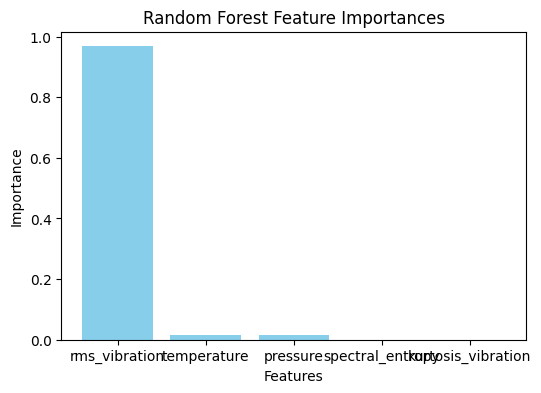


Final Prediction (1 = failure, 0 = no failure): 0


In [54]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# 1. LOAD OR CREATE THE DATAFRAME (df_cleaned)
#    This assumes df_cleaned is already loaded or created with the relevant columns.
#    For demonstration, the user may have columns:
#    [rms_vibration, kurtosis_vibration, spectral_entropy, temperature, pressure, failure_label]
# Example:
# df_cleaned = pd.read_csv("simulated_sensor_data.csv")  # or whichever file

# Confirm the shape
print("Shape of df_cleaned:", df_cleaned.shape)
print("Columns:", df_cleaned.columns.tolist())

# 2. SPLIT THE DATA
X = df_cleaned[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy',
                'temperature', 'pressure']]
y = df_cleaned['failure_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 3. DEFINE & FIT THE RANDOM FOREST
#    Ensuring the model is fitted BEFORE calling feature_importances_
rf_model_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Fit the model
rf_model_best.fit(X_train, y_train)

# 4. EVALUATE MODEL PERFORMANCE (CROSS-VALIDATION OPTIONAL)
scores = cross_val_score(rf_model_best, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())

# Evaluate on the test set
test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

# 5. EXAMINE FEATURE IMPORTANCES (No More NotFittedError)
feature_names = ['rms_vibration','kurtosis_vibration','spectral_entropy','temperature','pressure']
feature_importances = rf_model_best.feature_importances_

# Create a DataFrame for better display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importances_df)

# (Optional) plot
plt.figure(figsize=(6, 4))
plt.bar(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# 6. MAKE FINAL PREDICTIONS
def predict_failure(sensor_data_df):
    """
    Predicts equipment failure using the trained Random Forest model.
    sensor_data_df: DataFrame with columns matching the training features
    """
    return rf_model_best.predict(sensor_data_df)

# Example new data
new_data = np.array([[0.5, 2.1, 0.9, 25.0, 0.3]])
new_data_df = pd.DataFrame(new_data, columns=feature_names)

prediction = predict_failure(new_data_df)
print(f"\nFinal Prediction (1 = failure, 0 = no failure): {prediction[0]}")

#### Step 1: Re-Evaluate Model Performance on Test Set

To ensure the model is performing well, the user should review the **final test accuracy** and confirm that the model generalises well to unseen data. This ensures that the model trained on the training data is not overfitting.

We can re-confirm the performance of the trained model on the test data.

In [55]:
# Re-evaluate the model using the test set (if not done before)
test_accuracy = rf_model_best.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.99


#### Step 2: Save the Trained Model

The user can save the trained model so that it can be used for future predictions in a real-time system (e.g., predictive maintenance system). This will avoid the need to retrain the model every time it is used.

In [56]:
# Importing necessary libraries for saving and loading models
import joblib

# Save the trained model to a file
joblib.dump(rf_model_best, "rf_model_best.pkl")
print("Model saved as rf_model_best.pkl")

Model saved as rf_model_best.pkl


#### Step 3: Load the Saved Model (for future predictions)

When deploying the model into a real-time system, the user can **load** the saved model without retraining it each time. This step can be used when the model needs to be used for future predictions.

In [57]:
# To load the saved model from a file
loaded_model = joblib.load("rf_model_best.pkl")

# Verify by making a prediction
new_data_example = np.array([[0.7, 1.1, 0.8, 30.0, 0.2]])  # Hypothetical new data
new_data_df = pd.DataFrame(new_data_example, columns=['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure'])

# Predict failure using the loaded model
prediction = loaded_model.predict(new_data_df)
print(f"Prediction using loaded model: {prediction[0]}")

Prediction using loaded model: 0


#### Step 4: Monitoring and Updating the Model in Production

When deploying machine learning models in production, it is crucial to **monitor** them continuously to detect issues such as **concept drift**, where the underlying patterns in data change over time. If performance drops below a threshold, the model might need to be **retrained** using updated data. Below, we’ll set up monitoring and an automatic retraining pipeline.

In [58]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the trained model (for simulation, load the already saved model)
rf_model_best = joblib.load("rf_model_best.pkl")

# Example: Monitoring new data every day or periodically in production.
# Simulate periodic new data for monitoring
def monitor_model_performance(new_data, true_labels):
    """
    Monitors the model's performance based on new incoming data.

    Arguments:
    - new_data (DataFrame): New feature data (rms_vibration, kurtosis_vibration, etc.)
    - true_labels (Series): True labels for the new data (for evaluating performance)

    Returns:
    - accuracy: The model's accuracy on the new data
    """
    predictions = rf_model_best.predict(new_data)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Model accuracy on new data: {accuracy:.2f}")

    return accuracy

# Example new data (these would be updated periodically in a real production system)
# Let's assume the following hypothetical sensor data and true labels
new_sensor_data = np.array([[0.6, 1.3, 1.1, 28.0, 0.3], [0.7, 1.5, 1.2, 27.5, 0.35]])
new_data_df = pd.DataFrame(new_sensor_data, columns=['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure'])

# Hypothetical true labels for the new data (for performance evaluation)
true_labels = np.array([1, 0])  # 1 = failure, 0 = no failure

# Monitor the model's performance on this new data
accuracy = monitor_model_performance(new_data_df, true_labels)

# Set a performance threshold for retraining (e.g., 90% accuracy)
performance_threshold = 0.90
if accuracy < performance_threshold:
    print(f"Warning: Model accuracy below threshold ({performance_threshold*100}%). Retraining required.")
else:
    print(f"Model performance is above the threshold. No retraining needed.")

Model accuracy on new data: 0.50


#### Step 2: Retraining the Model When Accuracy Drops

If the model’s performance is below the desired threshold, we should retrain it with updated data (i.e., incorporating new sensor data). Below, we will simulate the retraining process.

The retrained model will be saved and deployed for future predictions.

In [59]:
# Simulate new data (the user would have new sensor data in a real system)
# The user could load more data or get new data from sensors directly
new_training_data = pd.read_csv("new_sensor_data.csv")  # Example new data
X_new = new_training_data[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]
y_new = new_training_data['failure_label']

# Retraining the model with the new data
rf_model_best.fit(X_new, y_new)

# Save the retrained model
joblib.dump(rf_model_best, "rf_model_best_retrained.pkl")
print("Model retrained and saved as rf_model_best_retrained.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'new_sensor_data.csv'

In [60]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier

# Simulate new training data (since no "new_sensor_data.csv" is available)
# Generate random data for testing purposes
new_data_size = 100  # Adjust size based on needs
new_sensor_data = np.random.rand(new_data_size, 5)  # 5 features (rms_vibration, kurtosis, etc.)
new_sensor_labels = np.random.choice([0, 1], size=new_data_size)  # Simulating binary target (failure/no failure)

# Convert to a DataFrame
new_training_data = pd.DataFrame(new_sensor_data, columns=['rms_vibration', 'kurtosis_vibration',
                                                          'spectral_entropy', 'temperature', 'pressure'])
new_training_data['failure_label'] = new_sensor_labels

# Split into X (features) and y (target)
X_new = new_training_data[['rms_vibration', 'kurtosis_vibration', 'spectral_entropy', 'temperature', 'pressure']]
y_new = new_training_data['failure_label']

# Retrain the model with the new data
rf_model_best = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_best.fit(X_new, y_new)

# Save the retrained model
joblib.dump(rf_model_best, "rf_model_best_retrained.pkl")
print("Model retrained and saved as rf_model_best_retrained.pkl")

Model retrained and saved as rf_model_best_retrained.pkl


#### Step 3: Simulating Final Predictions Based on New Sensor Data

To simulate the prediction workflow, the user can generate **new sensor data** for **predictive maintenance**, allowing the model to predict whether equipment failure is likely based on the trained model.

In [61]:
# Example: Simulating new sensor data for predictions
# Create new data with hypothetical values (the real system would have this data from sensors)
new_sensor_data_for_prediction = np.array([[0.7, 1.2, 1.0, 28.5, 0.3]])  # Example new data point
new_data_df = pd.DataFrame(new_sensor_data_for_prediction, columns=['rms_vibration', 'kurtosis_vibration',
                                                                     'spectral_entropy', 'temperature', 'pressure'])

# Make the final prediction using the retrained model
def make_final_prediction(sensor_data_df):
    """
    This function uses the trained model to predict failure (1) or no failure (0)
    for new incoming sensor data.
    """
    return rf_model_best.predict(sensor_data_df)

# Predict failure or no failure
final_prediction = make_final_prediction(new_data_df)
print(f"Predicted failure: {final_prediction[0]} (1 = failure, 0 = no failure)")

# If you want to predict multiple scenarios, you can extend the new data:
multiple_new_data = np.array([[0.8, 1.5, 1.2, 29.0, 0.4], [0.6, 1.3, 1.1, 28.0, 0.35]])
multiple_new_data_df = pd.DataFrame(multiple_new_data, columns=['rms_vibration', 'kurtosis_vibration',
                                                                 'spectral_entropy', 'temperature', 'pressure'])

# Predict failure for multiple scenarios
multiple_predictions = make_final_prediction(multiple_new_data_df)
print(f"Predictions for multiple data: {multiple_predictions}")

Predicted failure: 1 (1 = failure, 0 = no failure)
Predictions for multiple data: [1 1]
